In [1]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt
plt.style.use('dark_background')

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('popornot.csv')
df['penalized_cpm'] = df.changes_per_minute / df.confidence_penalty
df['penalized_variety'] = df.variety / df.confidence_penalty
df['penalized_duration'] = df.duration_score / df.confidence_penalty

In [4]:
df[df['pop'] == 1].shape[0], df[df['pop'] == 0 ].shape[0]

(251, 159)

/home/matt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/matt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


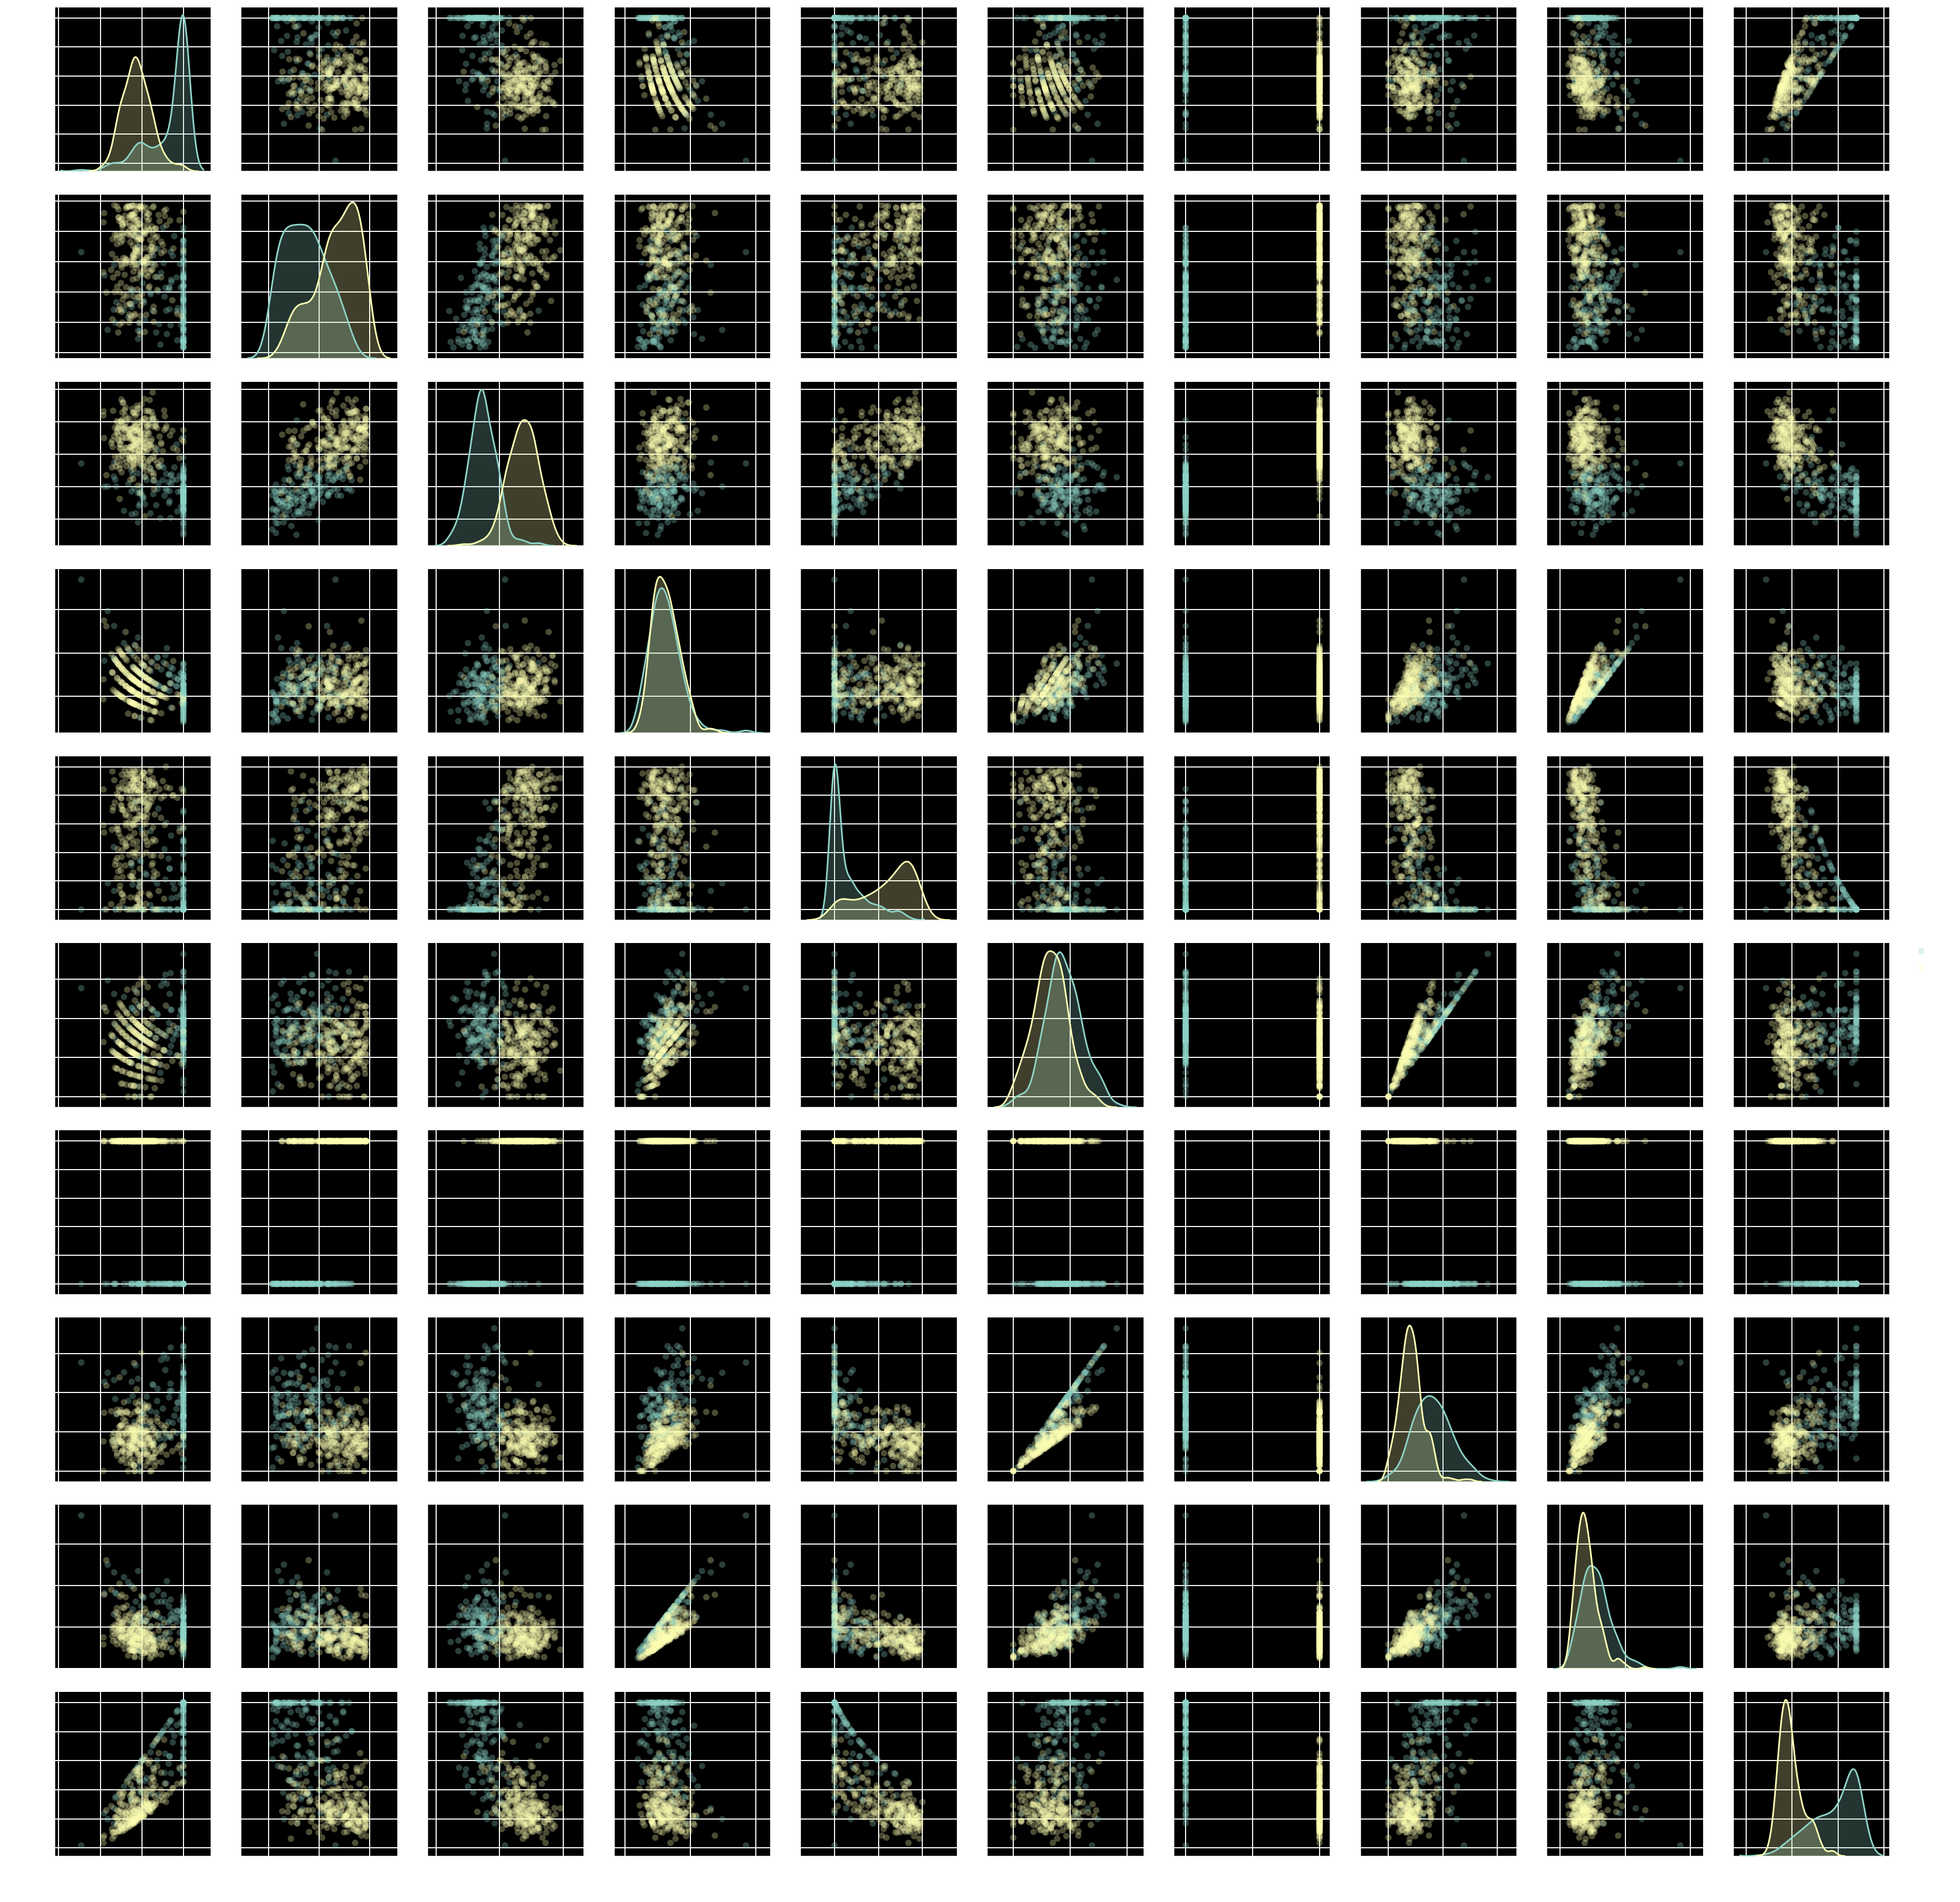

In [5]:
sns.pairplot(df, hue='pop', plot_kws=dict(alpha=.3, edgecolor='none'))

In [7]:
features = ['danceability', 'penalized_cpm', 'penalized_duration', 'penalized_variety', 'valence']
X = df[features]
y = df['pop']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=12)

In [8]:
lrr = LogisticRegression()
lrr.fit(X_train, y_train)
lrr.score(X_train, y_train), lrr.score(X_test, y_test)

/home/matt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.9303135888501742, 0.8780487804878049)

In [15]:
import operator as op
probs = lrr.predict_proba(X)
df['prob_pop'],  df['result'] = list(map(op.itemgetter(1), probs)), lrr.predict(X)
df.sample(15)[['artist', 'name', 'prob_pop']]

artist  \
179                     flora cash   
189                      push baby   
307                      Trey Gunn   
335                   Spooky Tooth   
80                  Spandau Ballet   
389                   King Crimson   
154                  Fox Stevenson   
270           Far East Family Band   
86                The Human League   
43                         Tiffany   
207  Blackstreet,Dr. Dre,Queen Pen   
386                   Gentle Giant   
208                  Janet Jackson   
36                      Billy Joel   
287         Emerson, Lake & Palmer   

                                                 name  prob_pop  
179                                      Missing Home  0.807362  
189                                   CALI SUPERBLOOM  0.352613  
307  The Joy of Molybdenum (feat. The Trey Gunn Band)  0.264320  
335                                        Evil Woman  0.064360  
80                                 TRUE - Single Edit  0.877135  
389                                    Frame By Frame  0.076293  
154                                       Out My Head  0.882453  
270                                          Timeless  0.093892  
86      Together In Electric Dreams - 2003 - Remaster  0.962469  
43                            I Think We're Alone Now  0.988449  
207                                        No Diggity  0.685635  
386                                        Experience  0.030954  
208                                     Rhythm Nation  0.855481  
36                                        Uptown Girl  0.961003  
287                                     Take A Pebble  0.017305

In [41]:
threshold = .35
y_predict = (lrr.predict_proba(X_test)[:,1] > threshold)
print(f"Threshold of {threshold:4.2f}")
print("Precision: {:6.3f},   Recall: {:6.3f}, F1: {:6.3f}, ROC/AUC: {:6.3f}".format(
    precision_score(y_test, y_predict), 
    recall_score(y_test, y_predict), 
    f1_score(y_test, y_predict),
    roc_auc_score(y_test, y_predict)
))

Threshold of 0.35
Precision:  0.850,   Recall:  0.986, F1:  0.913, ROC/AUC:  0.882


([<matplotlib.axis.YTick at 0x7efe908b90b8>,
 <a list of 8 Text yticklabel objects>)

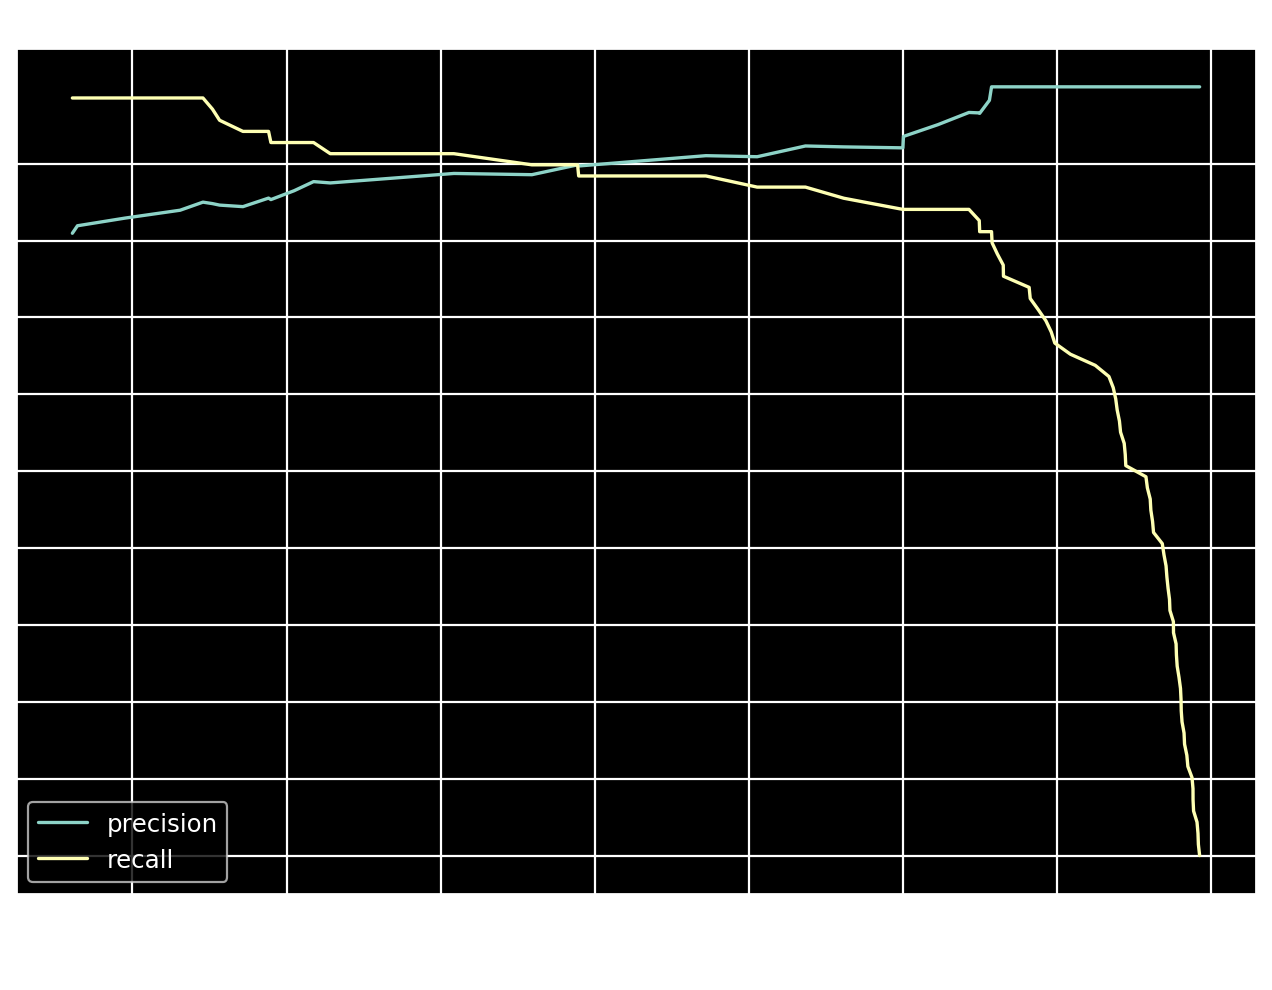

In [37]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lrr.predict_proba(X_test)[:,1] )
plt.figure(dpi=80, figsize=(10,7))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('R');
locs, labels = plt.yticks()
yaxis = np.arange(0, 1.0, .1)
plt.yticks(yaxis, labels)